In [3]:
import json

# === CONFIGURAZIONE ===
input_file = 'json_valeria/3.json'
output_file = 'polygon.json'

# === FUNZIONE DI CONVERSIONE ===
def estrai_poligono_da_json(percorso_file):
    with open(percorso_file, 'r') as f:
        data = json.load(f)
    
    lines = data.get("lines", [])
    if not lines:
        raise ValueError("Nessuna linea trovata nel file JSON.")

    # Costruisci il poligono come lista di coordinate
    polygon = [[line["x1"], line["y1"]] for line in lines]
    polygon.append([lines[-1]["x2"], lines[-1]["y2"]])  # chiusura del poligono

    return polygon

# === SALVATAGGIO SU FILE ===
def salva_poligono_su_file(polygon, percorso_output):
    with open(percorso_output, 'w') as f:
        json.dump(polygon, f, indent=2)

# === ESECUZIONE ===
if __name__ == "__main__":
    try:
        poligono = estrai_poligono_da_json(input_file)
        salva_poligono_su_file(poligono, output_file)
        print(f"Poligono salvato in '{output_file}' con successo.")
    except Exception as e:
        print(f"Errore: {e}")

Poligono salvato in 'polygon.json' con successo.


Rotazione 0° -> Totale cerchi: 105
Rotazione 2° -> Totale cerchi: 108
Rotazione 4° -> Totale cerchi: 104
Rotazione 6° -> Totale cerchi: 101
Rotazione 8° -> Totale cerchi: 102
Rotazione 10° -> Totale cerchi: 105
Rotazione 12° -> Totale cerchi: 104
Rotazione 14° -> Totale cerchi: 103
Rotazione 16° -> Totale cerchi: 103
Rotazione 18° -> Totale cerchi: 102
Rotazione 20° -> Totale cerchi: 103
Rotazione 22° -> Totale cerchi: 104
Rotazione 24° -> Totale cerchi: 100
Rotazione 26° -> Totale cerchi: 101
Rotazione 28° -> Totale cerchi: 101
Rotazione 30° -> Totale cerchi: 102
Rotazione 32° -> Totale cerchi: 100
Rotazione 34° -> Totale cerchi: 104
Rotazione 36° -> Totale cerchi: 102
Rotazione 38° -> Totale cerchi: 103
Rotazione 40° -> Totale cerchi: 102
Rotazione 42° -> Totale cerchi: 102
Rotazione 44° -> Totale cerchi: 103
Rotazione 46° -> Totale cerchi: 104
Rotazione 48° -> Totale cerchi: 101
Rotazione 50° -> Totale cerchi: 104
Rotazione 52° -> Totale cerchi: 105
Rotazione 54° -> Totale cerchi: 1

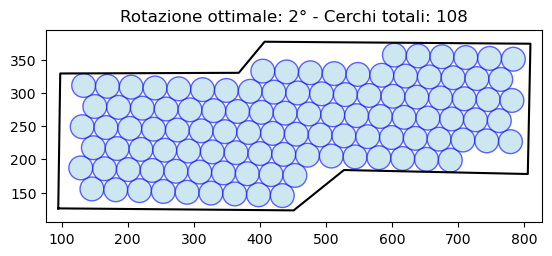

Rotazione migliore: 2°, Totale cerchi: 108
Risultato esportato in 'polygon_with_circles.json'


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
from shapely import affinity
from shapely.ops import unary_union
import json


def generate_hex_grid(polygon: Polygon, radius: float, angle: float = 0):
    # Applica rotazione al poligono
    rotated_polygon = affinity.rotate(polygon, angle, origin='centroid')
    
    minx, miny, maxx, maxy = rotated_polygon.bounds

    dx = 2 * radius
    dy = np.sqrt(3) * radius

    points = []
    y = miny
    row = 0
    while y <= maxy:
        x = minx + (radius if row % 2 else 0)
        while x <= maxx:
            center = Point(x, y)
            if rotated_polygon.contains(center.buffer(radius)):
                points.append((x, y))
            x += dx
        y += dy
        row += 1

    # Ruota indietro i punti
    rotated_back = [affinity.rotate(Point(x, y), -angle, origin=polygon.centroid) for x, y in points]
    return [(p.x, p.y) for p in rotated_back]


#metodo che controlla se un nuovo cerchio può essere aggiunto senza collisioni
def add_extra_circles(polygon: Polygon, existing_centers: list, radius: float, spacing: float = 0.5):
    minx, miny, maxx, maxy = polygon.bounds
    new_points = []

    # Crea i buffer dei cerchi esistenti per confronto geometrico
    existing_buffers = [Point(x, y).buffer(radius) for x, y in existing_centers]
    all_buffers = unary_union(existing_buffers)  # Unione dei cerchi già piazzati

    dx = spacing * radius
    dy = spacing * radius

    x_vals = np.arange(minx, maxx + dx, dx)
    y_vals = np.arange(miny, maxy + dy, dy)

    for x in x_vals:
        for y in y_vals:
            center = Point(x, y)
            buffer = center.buffer(radius)

            if not polygon.contains(buffer):
                continue

            # Controllo preciso: il nuovo cerchio non deve intersecare altri
            if all_buffers.intersects(buffer):
                continue

            # Aggiungilo e aggiorna unione
            new_points.append((x, y))
            all_buffers = unary_union([all_buffers, buffer])

    return new_points



def plot_packing(polygon: Polygon, centers: list, radius: float, title="Packing"):
    fig, ax = plt.subplots()
    x, y = polygon.exterior.xy
    ax.plot(x, y, color='black')

    for cx, cy in centers:
        circle = plt.Circle((cx, cy), radius, edgecolor='blue', facecolor='lightblue', alpha=0.6)
        ax.add_patch(circle)

    ax.set_aspect('equal')
    ax.set_xlim(polygon.bounds[0] - radius, polygon.bounds[2] + radius)
    ax.set_ylim(polygon.bounds[1] - radius, polygon.bounds[3] + radius)
    plt.title(f"{title} - Cerchi totali: {len(centers)}")
    plt.show()


#metodo che trova la rotazione ottimale per il packing
def find_best_rotation(polygon: Polygon, radius: float, angles=None):
    if angles is None:
        angles = np.arange(0, 62, 2)  # Rotazioni da 0° a 55° ogni 5°

    best_centers = []
    best_angle = 0

    for angle in angles:
        base_centers = generate_hex_grid(polygon, radius, angle=angle)
        extra_centers = add_extra_circles(polygon, base_centers, radius)
        total = base_centers + extra_centers

        print(f"Rotazione {angle}° -> Totale cerchi: {len(total)}")
        if len(total) > len(best_centers):
            best_centers = total
            best_angle = angle

    return best_centers, best_angle


if __name__ == "__main__":
    # Carica i punti
    with open("polygon.json", "r") as f:
        vertices = json.load(f)

    # Separali in X e Y
    x, y = zip(*vertices)
    poly = Polygon(vertices)

    circle_radius = 18

    # Trova la miglior disposizione
    best_centers, best_angle = find_best_rotation(poly, circle_radius)

    # Visualizza
    plot_packing(poly, best_centers, circle_radius, title=f"Rotazione ottimale: {best_angle}°")
    print(f"Rotazione migliore: {best_angle}°, Totale cerchi: {len(best_centers)}")

    # Prepara il JSON da esportare
    export_data = {
        "polygon": vertices,
        "circles": [
            {"center": [x, y], "radius": circle_radius}
            for x, y in best_centers
        ]
    }

    # Esporta in JSON
    with open("polygon_with_circles.json", "w") as f:
        json.dump(export_data, f, indent=2)

    print("Risultato esportato in 'polygon_with_circles.json'")

Rotazione 0° -> Totale cerchi: 105
Rotazione 2° -> Totale cerchi: 108
Rotazione 4° -> Totale cerchi: 104
Rotazione 6° -> Totale cerchi: 101
Rotazione 8° -> Totale cerchi: 102
Rotazione 10° -> Totale cerchi: 105
Rotazione 12° -> Totale cerchi: 104
Rotazione 14° -> Totale cerchi: 103
Rotazione 16° -> Totale cerchi: 103
Rotazione 18° -> Totale cerchi: 102
Rotazione 20° -> Totale cerchi: 103
Rotazione 22° -> Totale cerchi: 104
Rotazione 24° -> Totale cerchi: 100
Rotazione 26° -> Totale cerchi: 101
Rotazione 28° -> Totale cerchi: 101
Rotazione 30° -> Totale cerchi: 102
Rotazione 32° -> Totale cerchi: 100
Rotazione 34° -> Totale cerchi: 104
Rotazione 36° -> Totale cerchi: 102
Rotazione 38° -> Totale cerchi: 103
Rotazione 40° -> Totale cerchi: 102
Rotazione 42° -> Totale cerchi: 102
Rotazione 44° -> Totale cerchi: 103
Rotazione 46° -> Totale cerchi: 104
Rotazione 48° -> Totale cerchi: 101
Rotazione 50° -> Totale cerchi: 104
Rotazione 52° -> Totale cerchi: 105
Rotazione 54° -> Totale cerchi: 1

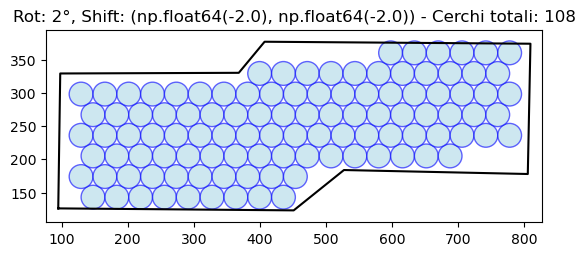

Rotazione migliore: 2°, Totale cerchi: 108
Risultato esportato in 'polygon_with_circles.json'


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
from shapely import affinity
from shapely.ops import unary_union
import json


def generate_hex_grid(polygon: Polygon, radius: float, angle: float = 0):
    # Applica rotazione al poligono
    rotated_polygon = affinity.rotate(polygon, angle, origin='centroid')
    
    minx, miny, maxx, maxy = rotated_polygon.bounds

    dx = 2 * radius
    dy = np.sqrt(3) * radius

    points = []
    y = miny
    row = 0
    while y <= maxy:
        x = minx + (radius if row % 2 else 0)
        while x <= maxx:
            center = Point(x, y)
            if rotated_polygon.contains(center.buffer(radius)):
                points.append((x, y))
            x += dx
        y += dy
        row += 1

    # Ruota indietro i punti
    rotated_back = [affinity.rotate(Point(x, y), -angle, origin=polygon.centroid) for x, y in points]
    return [(p.x, p.y) for p in rotated_back]


#metodo che controlla se un nuovo cerchio può essere aggiunto senza collisioni
def add_extra_circles(polygon: Polygon, existing_centers: list, radius: float, spacing: float = 0.5):
    minx, miny, maxx, maxy = polygon.bounds
    new_points = []

    # Crea i buffer dei cerchi esistenti per confronto geometrico
    existing_buffers = [Point(x, y).buffer(radius) for x, y in existing_centers]
    all_buffers = unary_union(existing_buffers)  # Unione dei cerchi già piazzati

    dx = spacing * radius
    dy = spacing * radius

    x_vals = np.arange(minx, maxx + dx, dx)
    y_vals = np.arange(miny, maxy + dy, dy)

    for x in x_vals:
        for y in y_vals:
            center = Point(x, y)
            buffer = center.buffer(radius)

            if not polygon.contains(buffer):
                continue

            # Controllo preciso: il nuovo cerchio non deve intersecare altri
            if all_buffers.intersects(buffer):
                continue

            # Aggiungilo e aggiorna unione
            new_points.append((x, y))
            all_buffers = unary_union([all_buffers, buffer])

    return new_points



def plot_packing(polygon: Polygon, centers: list, radius: float, title="Packing"):
    fig, ax = plt.subplots()
    x, y = polygon.exterior.xy
    ax.plot(x, y, color='black')

    for cx, cy in centers:
        circle = plt.Circle((cx, cy), radius, edgecolor='blue', facecolor='lightblue', alpha=0.6)
        ax.add_patch(circle)

    ax.set_aspect('equal')
    ax.set_xlim(polygon.bounds[0] - radius, polygon.bounds[2] + radius)
    ax.set_ylim(polygon.bounds[1] - radius, polygon.bounds[3] + radius)
    plt.title(f"{title} - Cerchi totali: {len(centers)}")
    plt.show()


#metodo che trova la rotazione ottimale per il packing
def find_best_rotation_and_shift(polygon: Polygon, radius: float, coarse_angles=None, fine_shift_range=2.0, shift_step=1.0):
    if coarse_angles is None:
        coarse_angles = np.arange(0, 61, 2)

    # Fase 1: Trova la miglior rotazione senza shift
    best_angle = 0
    max_count = 0
    for angle in coarse_angles:
        base_centers = generate_hex_grid(polygon, radius, angle=angle)
        extra_centers = add_extra_circles(polygon, base_centers, radius)
        total = base_centers + extra_centers
        print(f"Rotazione {angle}° -> Totale cerchi: {len(total)}")
        if len(total) > max_count:
            max_count = len(total)
            best_angle = angle

    # Fase 2: Shift raffinato solo sulla rotazione migliore
    rotated_polygon = affinity.rotate(polygon, best_angle, origin='centroid')
    best_centers = []
    best_shift = (0, 0)

    for dx in np.arange(-fine_shift_range, fine_shift_range + shift_step, shift_step):
        for dy in np.arange(-fine_shift_range, fine_shift_range + shift_step, shift_step):
            shifted_polygon = affinity.translate(rotated_polygon, xoff=dx, yoff=dy)
            base_centers = generate_hex_grid(shifted_polygon, radius, angle=0)
            extra_centers = add_extra_circles(shifted_polygon, base_centers, radius)
            total = base_centers + extra_centers
            if len(total) > len(best_centers):
                best_centers = total
                best_shift = (dx, dy)

    print(f"✔️ Rotazione: {best_angle}°, Shift ottimale: {best_shift}, Cerchi: {len(best_centers)}")
    return best_centers, best_angle, best_shift


if __name__ == "__main__":
    # Carica i punti
    with open("polygon.json", "r") as f:
        vertices = json.load(f)

    # Separali in X e Y
    x, y = zip(*vertices)
    poly = Polygon(vertices)

    circle_radius = 18

    # Trova la miglior disposizione
    best_centers, best_angle, best_shift = find_best_rotation_and_shift(poly, circle_radius)
    plot_packing(poly, best_centers, circle_radius, title=f"Rot: {best_angle}°, Shift: {best_shift}")
    print(f"Rotazione migliore: {best_angle}°, Totale cerchi: {len(best_centers)}")

    # Prepara il JSON da esportare
    export_data = {
        "polygon": vertices,
        "circles": [
            {"center": [x, y], "radius": circle_radius}
            for x, y in best_centers
        ]
    }

    # Esporta in JSON
    with open("polygon_with_circles.json", "w") as f:
        json.dump(export_data, f, indent=2)

    print("Risultato esportato in 'polygon_with_circles.json'")

In [5]:
def calcola_configurazione_batteria(v_cella, ah_cella, v_target, ah_target, celle_disponibili):
    s = round(v_target / v_cella)
    p = round(ah_target / ah_cella)
    totale = s * p

    print(f"Configurazione suggerita: {s}S{p}P")
    print(f"Celle totali richieste: {totale}")

    if totale <= celle_disponibili:
        print("Le celle entrano nella forma disponibile.")
    else:
        print("Troppe celle. Considera di abbassare la capacità o cambiare disposizione.")
    return s, p, totale

# Esempio
calcola_configurazione_batteria(
    v_cella=3.6,
    ah_cella=2.5,
    v_target=47,
    ah_target=22,
    celle_disponibili=125
)

Configurazione suggerita: 13S9P
Celle totali richieste: 117
Le celle entrano nella forma disponibile.


(13, 9, 117)

In [1]:
def trova_tutte_configurazioni(celle_totali, v_cella=3.6, ah_cella=2.5):
    configurazioni = []

    for s in range(1, celle_totali + 1):
        if celle_totali % s != 0:
            continue  # solo configurazioni intere
        p = celle_totali // s
        v_tot = s * v_cella
        ah_tot = p * ah_cella
        configurazioni.append((s, p, v_tot, ah_tot))

    if not configurazioni:
        raise ValueError("Nessuna configurazione valida trovata")

    # Massima tensione
    max_tensione = max(configurazioni, key=lambda x: x[2])

    # Massima capacità
    max_capacita = max(configurazioni, key=lambda x: x[3])

    # Bilanciata (tensione ≈ capacità in termini assoluti)
    bilanciata = min(configurazioni, key=lambda x: abs(x[2] - x[3]))

    return {
        "massima_tensione": max_tensione,
        "massima_capacita": max_capacita,
        "bilanciata": bilanciata
    }

def stampa_configurazioni(configs):
    for nome, (s, p, v, ah) in configs.items():
        label = {
            "massima_tensione": "Massima Tensione",
            "massima_capacita": "Massima Capacità",
            "bilanciata": "Bilanciata"
        }[nome]
        print(f"{label}: {s}S{p}P  →  {v:.2f} V, {ah:.2f} Ah")

# Esempio d'uso
if __name__ == "__main__":
    celle_totali = 117  # puoi cambiarlo
    configs = trova_tutte_configurazioni(celle_totali)
    stampa_configurazioni(configs)

Massima Tensione: 117S1P  →  421.20 V, 2.50 Ah
Massima Capacità: 1S117P  →  3.60 V, 292.50 Ah
Bilanciata: 9S13P  →  32.40 V, 32.50 Ah


Configurazione suggerita: 13S9P
Celle totali richieste: 117
✅ Le celle entrano nella forma disponibile.
Tentativo con distanza massima: 36.00
❌ Impossibile formare 13 gruppi di 9 celle adiacenti.
Tentativo con distanza massima: 45.00
✅ Gruppi trovati con distanza 45.00


/var/folders/20/448h2f1933x4jpn5p3l2lb7c0000gn/T/ipykernel_3235/872278894.py:84: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(gruppi))


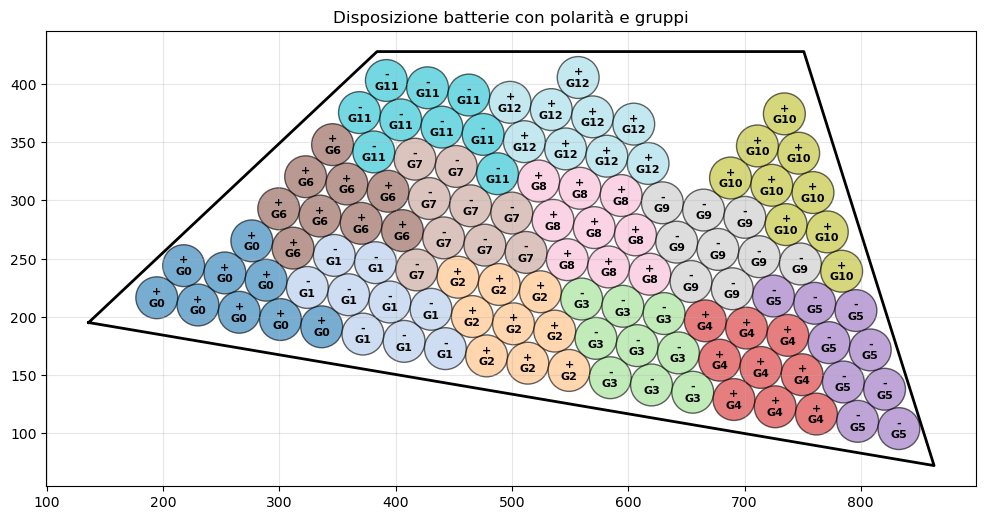

In [6]:
import json
import matplotlib.pyplot as plt
import numpy as np
from collections import deque
import networkx as nx

def calcola_configurazione_batteria(v_cella, ah_cella, v_target, ah_target, celle_disponibili):
    s = round(v_target / v_cella)
    p = round(ah_target / ah_cella)
    totale = s * p

    print(f"Configurazione suggerita: {s}S{p}P")
    print(f"Celle totali richieste: {totale}")

    if totale <= celle_disponibili:
        print("✅ Le celle entrano nella forma disponibile.")
    else:
        print("⚠️ Troppe celle. Considera di abbassare la capacità o cambiare disposizione.")
    return s, p, totale

def costruisci_grafo_adiacenza(centers, distanza_massima):
    G = nx.Graph()
    for i, c1 in enumerate(centers):
        G.add_node(i, center=c1)
    for i in range(len(centers)):
        for j in range(i + 1, len(centers)):
            dist = np.linalg.norm(np.array(centers[i]) - np.array(centers[j]))
            if dist <= distanza_massima:
                G.add_edge(i, j)
    return G

def estrai_gruppi_connessi(G, S, P):
    """Trova S gruppi distinti da P celle connesse usando BFS."""
    gruppi = []
    usate = set()

    for componente in nx.connected_components(G):
        nodi = list(componente)
        subG = G.subgraph(nodi)

        for nodo in nodi:
            if nodo in usate:
                continue

            visitati = set()
            gruppo = []
            coda = deque([nodo])

            while coda and len(gruppo) < P:
                current = coda.popleft()
                if current in visitati or current in usate:
                    continue
                visitati.add(current)
                gruppo.append(current)
                for vicino in G.neighbors(current):
                    if vicino not in visitati and vicino not in usate:
                        coda.append(vicino)

            if len(gruppo) == P:
                gruppi.append(gruppo)
                usate.update(gruppo)
                if len(gruppi) == S:
                    return gruppi
    raise ValueError(f"Impossibile formare {S} gruppi di {P} celle adiacenti.")

def trova_gruppi_con_raggio_adattivo(centers, radius, S, P, raggio_iniziale=2.0, raggio_massimo=6.0, passo=0.5):
    for moltiplicatore in np.arange(raggio_iniziale, raggio_massimo + passo, passo):
        distanza = moltiplicatore * radius
        print(f"Tentativo con distanza massima: {distanza:.2f}")
        G = costruisci_grafo_adiacenza(centers, distanza)
        try:
            gruppi = estrai_gruppi_connessi(G, S, P)
            print(f"✅ Gruppi trovati con distanza {distanza:.2f}")
            return gruppi
        except ValueError as e:
            print(f"❌ {e}")
    raise ValueError(f"Impossibile formare {S} gruppi di {P} celle adiacenti anche aumentando il raggio.")

def plot_labeled_battery(polygon, centers, radius, gruppi):
    fig, ax = plt.subplots(figsize=(12, 8))
    x, y = zip(*polygon)
    ax.plot(x, y, color='black', linewidth=2)

    colors = plt.cm.get_cmap('tab20', len(gruppi))
    for idx, gruppo in enumerate(gruppi):
        polarity = '+' if idx % 2 == 0 else '-'
        for n in gruppo:
            cx, cy = centers[n]
            circle = plt.Circle((cx, cy), radius, edgecolor='black', facecolor=colors(idx), alpha=0.6)
            ax.add_patch(circle)
            ax.text(cx, cy, f"{polarity}\nG{idx}", ha='center', va='center', fontsize=8, weight='bold')
    ax.set_aspect('equal')
    plt.grid(True, alpha=0.3)
    plt.title("Disposizione batterie con polarità e gruppi")
    plt.show()

if __name__ == "__main__":
    # 1. Calcola configurazione
    S, P, total = calcola_configurazione_batteria(
        v_cella=3.6,
        ah_cella=2.5,
        v_target=47,
        ah_target=22,
        celle_disponibili=125
    )

    # 2. Carica dati
    with open("polygon_with_circles.json", "r") as f:
        data = json.load(f)
    
    polygon = data["polygon"]
    circles = data["circles"]
    radius = circles[0]["radius"]
    centers = [tuple(c["center"]) for c in circles]

    # 3. Crea grafo e trova gruppi
    gruppi = trova_gruppi_con_raggio_adattivo(centers, radius, S, P)

    # 4. Visualizza
    plot_labeled_battery(polygon, centers, radius, gruppi)

Configurazione suggerita: 13S9P
Celle totali richieste: 117
✅ Le celle entrano nella forma disponibile.
Tentativo con distanza massima: 36.00
❌ Impossibile formare 13 gruppi di 9 celle adiacenti.
Tentativo con distanza massima: 45.00
✅ Gruppi trovati con distanza 45.00
✅ File salvato: polygon_with_circles_and_connections.json


/var/folders/20/448h2f1933x4jpn5p3l2lb7c0000gn/T/ipykernel_3235/1594406526.py:90: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(gruppi))


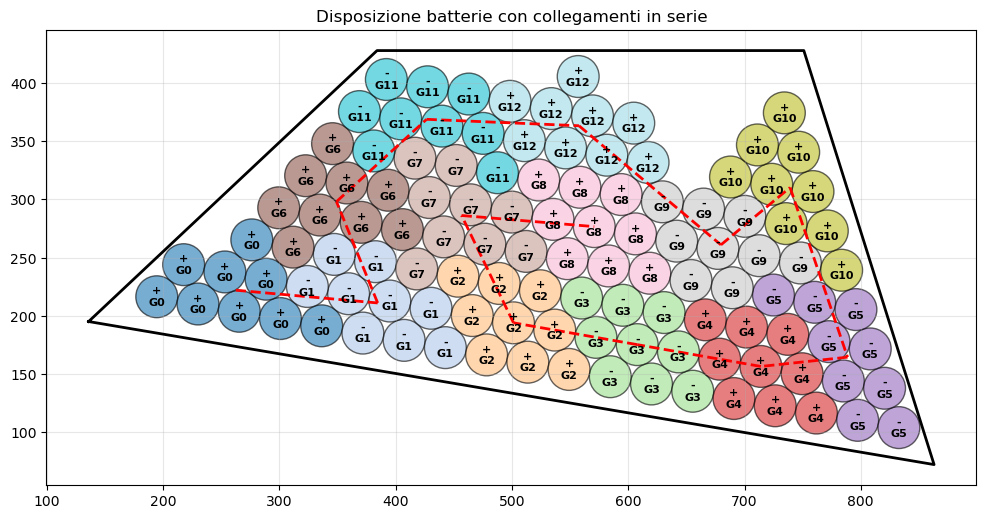

In [7]:
import json
import matplotlib.pyplot as plt
import numpy as np
from collections import deque
import networkx as nx

def calcola_configurazione_batteria(v_cella, ah_cella, v_target, ah_target, celle_disponibili):
    s = round(v_target / v_cella)
    p = round(ah_target / ah_cella)
    totale = s * p

    print(f"Configurazione suggerita: {s}S{p}P")
    print(f"Celle totali richieste: {totale}")

    if totale <= celle_disponibili:
        print("✅ Le celle entrano nella forma disponibile.")
    else:
        print("⚠️ Troppe celle. Considera di abbassare la capacità o cambiare disposizione.")
    return s, p, totale

def costruisci_grafo_adiacenza(centers, distanza_massima):
    G = nx.Graph()
    for i, c1 in enumerate(centers):
        G.add_node(i, center=c1)
    for i in range(len(centers)):
        for j in range(i + 1, len(centers)):
            dist = np.linalg.norm(np.array(centers[i]) - np.array(centers[j]))
            if dist <= distanza_massima:
                G.add_edge(i, j)
    return G

def estrai_gruppi_connessi(G, S, P):
    gruppi = []
    usate = set()

    for componente in nx.connected_components(G):
        nodi = list(componente)
        subG = G.subgraph(nodi)

        for nodo in nodi:
            if nodo in usate:
                continue

            visitati = set()
            gruppo = []
            coda = deque([nodo])

            while coda and len(gruppo) < P:
                current = coda.popleft()
                if current in visitati or current in usate:
                    continue
                visitati.add(current)
                gruppo.append(current)
                for vicino in G.neighbors(current):
                    if vicino not in visitati and vicino not in usate:
                        coda.append(vicino)

            if len(gruppo) == P:
                gruppi.append(gruppo)
                usate.update(gruppo)
                if len(gruppi) == S:
                    return gruppi
    raise ValueError(f"Impossibile formare {S} gruppi di {P} celle adiacenti.")

def trova_gruppi_con_raggio_adattivo(centers, radius, S, P, raggio_iniziale=2.0, raggio_massimo=6.0, passo=0.5):
    for moltiplicatore in np.arange(raggio_iniziale, raggio_massimo + passo, passo):
        distanza = moltiplicatore * radius
        print(f"Tentativo con distanza massima: {distanza:.2f}")
        G = costruisci_grafo_adiacenza(centers, distanza)
        try:
            gruppi = estrai_gruppi_connessi(G, S, P)
            print(f"✅ Gruppi trovati con distanza {distanza:.2f}")
            return gruppi
        except ValueError as e:
            print(f"❌ {e}")
    raise ValueError(f"Impossibile formare {S} gruppi di {P} celle adiacenti anche aumentando il raggio.")

def plot_batteria_con_collegamenti(data, radius):
    polygon = data["polygon"]
    circles = data["circles"]
    gruppi = data["gruppi"]
    connessioni = data["serie_connections"]

    centers = [tuple(c["center"]) for c in circles]

    fig, ax = plt.subplots(figsize=(12, 8))
    x, y = zip(*polygon)
    ax.plot(x, y, color='black', linewidth=2)

    colors = plt.cm.get_cmap('tab20', len(gruppi))
    for idx, gruppo in enumerate(gruppi):
        polarity = '+' if idx % 2 == 0 else '-'
        for n in gruppo:
            cx, cy = centers[n]
            circle = plt.Circle((cx, cy), radius, edgecolor='black', facecolor=colors(idx), alpha=0.6)
            ax.add_patch(circle)
            ax.text(cx, cy, f"{polarity}\nG{idx}", ha='center', va='center', fontsize=8, weight='bold')

    # Disegna collegamenti tra centroidi
    for conn in connessioni:
        x_vals = [conn["from"][0], conn["to"][0]]
        y_vals = [conn["from"][1], conn["to"][1]]
        ax.plot(x_vals, y_vals, color='red', linestyle='--', linewidth=2)

    ax.set_aspect('equal')
    plt.grid(True, alpha=0.3)
    plt.title("Disposizione batterie con collegamenti in serie")
    plt.show()

def calcola_centroidi_gruppi(centers, gruppi):
    centroidi = []
    for gruppo in gruppi:
        coords = np.array([centers[i] for i in gruppo])
        centroid = coords.mean(axis=0)
        centroidi.append(centroid.tolist())
    return centroidi

def crea_collegamenti_serie_ottimizzati(gruppi, centers, radius):
    # Costruisci il grafo dei gruppi
    G = nx.Graph()
    num_gruppi = len(gruppi)
    
    polarita = ['+' if i % 2 == 0 else '-' for i in range(num_gruppi)]
    centroidi = calcola_centroidi_gruppi(centers, gruppi)
    
    # Crea archi tra gruppi con polarità opposte e molte celle adiacenti
    for i in range(num_gruppi):
        for j in range(i + 1, num_gruppi):
            if polarita[i] == polarita[j]:
                continue  # Serve alternanza
            contatti = conta_celle_adiacenti(gruppi[i], gruppi[j], centers, soglia_distanza=2.5 * radius)
            if contatti > 0:
                distanza = np.linalg.norm(np.array(centroidi[i]) - np.array(centroidi[j]))
                # Pesiamo l'arco con la distanza penalizzata e il numero di contatti
                peso = distanza - 0.5 * contatti
                G.add_edge(i, j, weight=peso)

    # Trova cammino ottimo usando greedy alternando polarità
    connessioni = []
    visitati = set()
    nodo_corrente = 0
    visitati.add(nodo_corrente)

    while len(visitati) < num_gruppi:
        candidati = [
            (vicino, G[nodo_corrente][vicino]['weight'])
            for vicino in G.neighbors(nodo_corrente)
            if vicino not in visitati and polarita[vicino] != polarita[nodo_corrente]
        ]
        if not candidati:
            break  # Cammino interrotto
        prossimo, _ = min(candidati, key=lambda x: x[1])
        connessioni.append({
            "from": centroidi[nodo_corrente],
            "to": centroidi[prossimo]
        })
        nodo_corrente = prossimo
        visitati.add(nodo_corrente)

    return connessioni

def conta_celle_adiacenti(gruppo1, gruppo2, centers, soglia_distanza):
    count = 0
    for i in gruppo1:
        for j in gruppo2:
            dist = np.linalg.norm(np.array(centers[i]) - np.array(centers[j]))
            if dist <= soglia_distanza:
                count += 1
    return count

if __name__ == "__main__":
    # 1. Calcola configurazione
    S, P, total = calcola_configurazione_batteria(
        v_cella=3.6,
        ah_cella=2.5,
        v_target=47,
        ah_target=22,
        celle_disponibili=125
    )

    # 2. Carica dati originali
    with open("polygon_with_circles.json", "r") as f:
        data = json.load(f)
    
    polygon = data["polygon"]
    circles = data["circles"]
    radius = circles[0]["radius"]
    centers = [tuple(c["center"]) for c in circles]

    # 3. Trova gruppi
    gruppi = trova_gruppi_con_raggio_adattivo(centers, radius, S, P)

    # 4. Calcola centroidi e collegamenti
    centroidi = calcola_centroidi_gruppi(centers, gruppi)
    connessioni = crea_collegamenti_serie_ottimizzati(gruppi,centers,radius)

    # 5. Salva nuovo file con connessioni
    data_output = {
        "polygon": polygon,
        "circles": circles,
        "gruppi": gruppi,
        "serie_connections": connessioni
    }

    with open("polygon_with_circles_and_connections.json", "w") as f:
        json.dump(data_output, f, indent=2)

    print("✅ File salvato: polygon_with_circles_and_connections.json")

    # 6. Visualizza il file salvato
    with open("polygon_with_circles_and_connections.json", "r") as f:
        data_loaded = json.load(f)

    plot_batteria_con_collegamenti(data_loaded, radius)